In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta   
import ffmpeg
from matplotlib import animation
from src.plot_utils import draw_pitch
from IPython.display import HTML
import matplotlib as mpl
from celluloid import Camera
import datetime
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Loading preprocessed data

In [20]:
df = pd.read_json("./Data/sample_match_1.json")

In [21]:
df.head()

,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A9_x,A9_y,A10_x,A10_y,A12_x,A12_y,A13_x,A13_y,A14_x,A14_y
2,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,45.44072,3.40136,39.34632,18.62044,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,0.08,0.09984,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,45.44072,3.40136,39.34632,18.62044,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3,0.12,0.11856,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,45.44072,3.40136,39.34632,18.62044,NaN,NaN,NaN,NaN,NaN,NaN
5,1,4,0.16,0.12584,32.80184,33.92688,44.41556,35.03448,33.31184,32.18176,...,45.38976,3.42584,39.26624,18.68164,NaN,NaN,NaN,NaN,NaN,NaN
6,1,5,0.20,0.13416,32.80184,33.90088,44.38292,35.01056,33.33224,32.18592,...,45.32320,3.38436,39.16952,18.72924,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
first_half = df[df['Period'] == 1]
second_half = df[df['Period'] == 2]

### Calculating velocity from coordinates data

In [23]:
def moving_average(x, w):
    output = np.convolve(x, np.ones(w), 'valid') / w
    output = np.concatenate([output, np.array([output[-1]]*(w-1))])
    return output

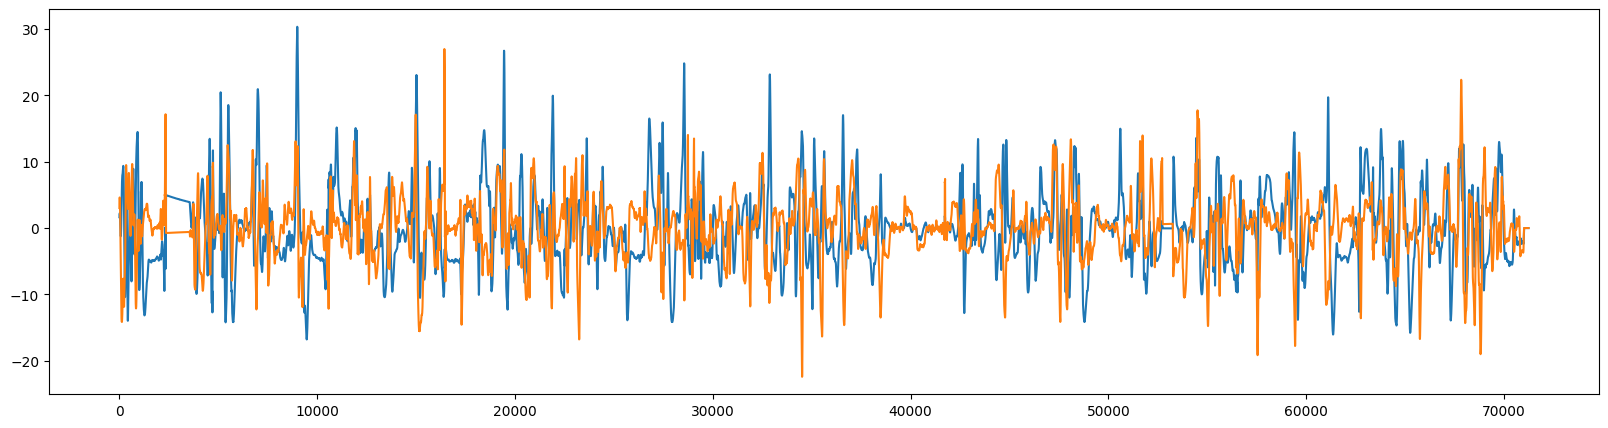

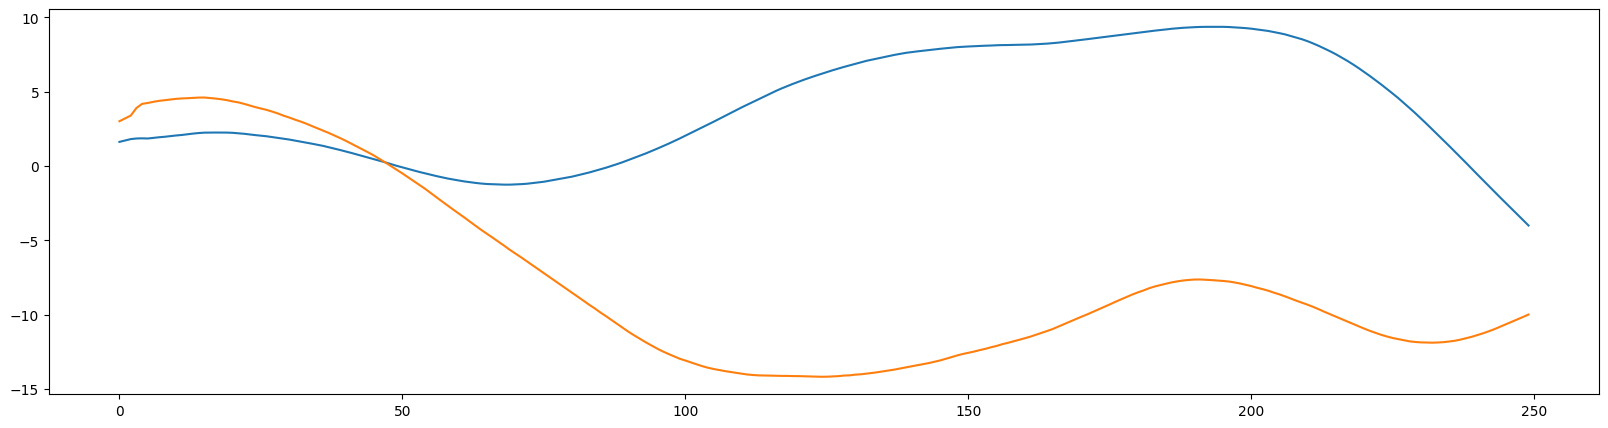

In [24]:
# Moving average 로 Smoothing (1초)
velocity_x = first_half['H2_x'] - first_half['H2_x'].shift(-1)
velocity_x = moving_average(velocity_x, 25)

velocity_y = first_half['H2_y'] - first_half['H2_y'].shift(-1)
velocity_y = moving_average(velocity_y, 25)

# x 좌표의 속도 (10초간)
plt.figure(figsize = (20, 5))
plt.plot(velocity_x*25*3.6)
plt.plot(velocity_y*25*3.6)

# y 좌표의 속도 (10초간)
plt.figure(figsize = (20, 5))
plt.plot(velocity_x[:250]*25*3.6)
plt.plot(velocity_y[:250]*25*3.6)

In [25]:
def v_abs(v_x, v_y):
    output = np.sqrt(v_x**2 + v_y**2)
    return output

In [26]:
for i in first_half.columns:
    if 'x' in i:
        t_xv = first_half[i] - first_half[i].shift(1)
        t_xv = moving_average(t_xv, 25)*25
        first_half[i+'_v'] = t_xv
    if 'y' in i:
        t_yv = first_half[i] - first_half[i].shift(1)
        t_yv = moving_average(t_yv, 25)*25
        first_half[i+'_v'] = t_yv
        first_half[i.split('_y')[0] + '_v_abs'] = [v_abs(vx, vy) for vx, vy in zip(t_xv, t_yv)]        

### Checking the output values

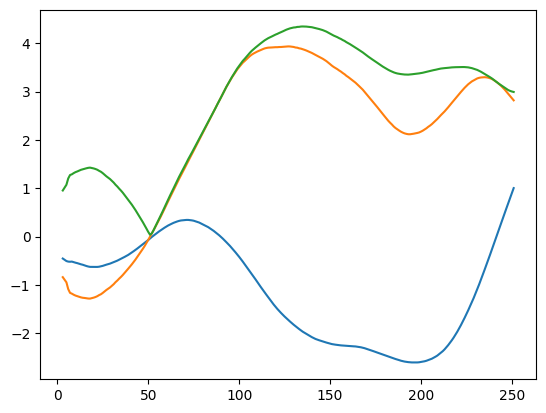

In [27]:
plt.plot(first_half['H2_x_v'][:250])
plt.plot(first_half['H2_y_v'][:250])
plt.plot(first_half['H2_v_abs'][:250])

In [28]:
for i in second_half.columns:
    if 'x' in i:
        t_xv = second_half[i] - second_half[i].shift(1)
        t_xv = moving_average(t_xv, 25)*25
        second_half[i+'_v'] = t_xv
    if 'y' in i:
        t_yv = second_half[i] - second_half[i].shift(1) 
        t_yv = moving_average(t_yv, 25)*25
        second_half[i+'_v'] = t_yv
        second_half[i.split('_y')[0] + '_v_abs'] = [v_abs(vx, vy) for vx, vy in zip(t_xv, t_yv)]     

In [29]:
f_df = pd.concat([first_half, second_half], axis=0)

In [31]:
f_df.to_json('./Data/sample_match_1_with_v.json')

In [32]:
df = pd.read_json("./Data/sample_match_2.json")
first_half = df[df['Period'] == 1]
second_half = df[df['Period'] == 2]

In [33]:
for i in first_half.columns:
    if 'x' in i:
        t_xv = first_half[i].shift(1) - first_half[i]
        t_xv = moving_average(t_xv, 25)*25
        first_half[i+'_v'] = t_xv
    if 'y' in i:
        t_yv = first_half[i].shift(1) - first_half[i]
        t_yv = moving_average(t_yv, 25)*25
        first_half[i+'_v'] = t_yv
        first_half[i.split('_y')[0] + '_v_abs'] = [v_abs(vx, vy) for vx, vy in zip(t_xv, t_yv)]        

In [36]:
def velocity_preprocessing(match_no):
    df = pd.read_json("./Data/sample_match_{}.json".format(match_no))

    first_half = df[df['Period'] == 1]
    second_half = df[df['Period'] == 2]
    
    for i in first_half.columns:
        if 'x' in i:
            t_xv = first_half[i] - first_half[i].shift(1)
            t_xv = moving_average(t_xv, 25)*25
            first_half[i+'_v'] = t_xv
        if 'y' in i:
            t_yv = first_half[i] - first_half[i].shift(1) 
            t_yv = moving_average(t_yv, 25)*25
            first_half[i+'_v'] = t_yv
            first_half[i.split('_y')[0] + '_v_abs'] = [v_abs(vx, vy) for vx, vy in zip(t_xv, t_yv)]        

    for i in second_half.columns:
        if 'x' in i:
            t_xv = second_half[i] - second_half[i].shift(1)
            t_xv = moving_average(t_xv, 25)*25
            second_half[i+'_v'] = t_xv
        if 'y' in i:
            t_yv = second_half[i] - second_half[i].shift(1)
            t_yv = moving_average(t_yv, 25)*25
            second_half[i+'_v'] = t_yv
            second_half[i.split('_y')[0] + '_v_abs'] = [v_abs(vx, vy) for vx, vy in zip(t_xv, t_yv)]    

    f_df = pd.concat([first_half, second_half], axis=0)
    f_df.to_json('./Data/sample_match_{}_with_v.json'.format(match_no))
    return f_df

In [37]:
df = velocity_preprocessing(1)

In [38]:
df.head()


,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A10_v_abs,A12_x_v,A12_y_v,A12_v_abs,A13_x_v,A13_y_v,A13_v_abs,A14_x_v,A14_y_v,A14_v_abs
2,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,0.08,0.09984,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,2.910703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3,0.12,0.11856,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,3.028292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,4,0.16,0.12584,32.80184,33.92688,44.41556,35.03448,33.31184,32.18176,...,3.144990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,5,0.20,0.13416,32.80184,33.90088,44.38292,35.01056,33.33224,32.18592,...,3.163107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df2 = velocity_preprocessing(2)